# 6　多次元尺度構成法とt-SNEのはなし
低次元でない入力空間のクラスタリングは一般に、クラスタリングに適したデータの配置を持つ低次元空間（2, 3次元など）を次元削減によって一度実現してから、何かしらの方法でクラスタリングするという手法をとります。このようなケースに用いられる次元削減には、主成分分析のように再構成誤差を最小化するタイプの次元削減のほかにも

* 入力空間上の各点間の距離を保つように低次元空間に変換する。

ような次元削減が用いられることがあります。そのような次元削減の手法として多次元尺度構成法とt-SNEがあります。このノートでは多次元尺度構成法とt-SNEの概要を紹介しましょう。

## A　多次元尺度構成法の概要とデモ

多次元尺度構成法は、入力空間上の各点間のユークリッド距離を保つように低次元空間に点を再配置する手法のことです。入力空間を$\mathcal{X}$, 圧縮する潜在空間を$\mathcal{Y}$と書くことにします。$\mathcal{Y}$の次元（圧縮する次元の数）は多次元尺度構成法のハイパーパラメータです。低次元空間への変換器を$F:\mathcal{X}\rightarrow\mathcal{Y}$と書いたとき、

\begin{align*}
L(x) &= \sum_{i\neq j}(d(F(x_{i}),F(x_{j}))-d(x_{i},x_{j}))^2
\end{align*}

が最小になるような点の配置を与える変換器$F$を求めるのが多次元尺度構成法です。

### digit dataset
`sklearn`パッケージの`datasets`モジュールに`load_digits`メソッドがあります。このメソッドを用いることで、64次元の0-9までの手書き数字が映っている画像1797枚を`numpy.2darray`として読み込むことが出来ます。

In [1]:
# データの読み込み
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data    # インスタンス変数 data に画像が準備されている。
X.shape

(1797, 64)

In [2]:
X[0,:]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

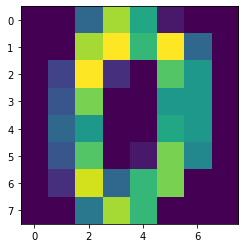

In [3]:
import matplotlib.pyplot as plt
plt.imshow(X[0, :].reshape(8, 8))
plt.show()

In [4]:
X[1,:]

array([ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,
        9.,  0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7.,
       15., 16., 16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,
        0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16.,
       16.,  6.,  0.,  0.,  0.,  0.,  0., 11., 16., 10.,  0.,  0.])

In [5]:
# あとで結果を確認するために、各画像のラベルを保存する。
labels = digits.target    # インスタンス変数 target に画像に映っている数字が準備されている。
labels.shape

(1797,)

### 多次元尺度構成法のsklearnによるコーディング

`sklearn`パッケージの`manifold`モジュールに多次元尺度構成法の実装である`MDS`クラスがあります。`MDS`クラスは圧縮先の空間の次元数に対応する`n_components`という名前の引数を持っています。small MNIST datasetを多次元尺度構成法を用いて次元圧縮してみましょう。

In [ ]:
# 多次元尺度構成法の学習
import time
from sklearn.manifold import MDS
mds = MDS(n_components = 2)
Y = mds.fit_transform(X)
Y.shape

In [ ]:
# 計算結果の可視化
import matplotlib.pyplot as plt
%matplotlib inline
cmp = plt.get_cmap("Set1")
plt.figure(figsize = (10, 10))
for i in range(10):
    flag = labels == i
    Y_selected = Y[flag, :]
    plt.scatter(Y_selected[:,0], Y_selected[:,1], color = cmp(i), marker = f"${i}$")
plt.title("result of MDS")
plt.show()

In [ ]:
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

## B　MDSの数理
MDSの学習は以下のような線型代数のテクニックの組み合わせることで行われています。

 * 機械学習で用いられる有用な行列
 * 距離と内積の関係 
 * 対称行列の分解
 
まずは、これらを順に説明していきます。

#### 機械学習で用いられる有用な行列

線型代数の基本的な知識は統計学や機械学習の理論においても非常に重要なツールです。

たとえば、以下のような行列は統計学や機械学習の理論ではよく出てきます。

 * $\mathbb{1}_n \mathbb{1}_n^{T}$
 * 中心化行列$J_n = E_n -\frac{1}{n}\mathbb{1}_n \mathbb{1}_n^{T}$

### $\mathbb{1}_n \mathbb{1}_n^{T}$

すべての成分が1であるような$n$次列ベクトルを$\mathbb{1}_n$と表すことにします。
このとき、$\mathbb{1}_n \mathbb{1}_n^{T}$はすべての成分が1であるような$n$次正方行列です。

**問**

$n$次正方行列$A$について、$A\mathbb{1}_n \mathbb{1}_n^{T}$, $\mathbb{1}_n \mathbb{1}_n^{T}A$はどのような行列になるでしょうか。
また、$A$が対角行列の場合はどうなりますか？

**ヒント**
 * n=3として、いろいろな3次正方行列Aに対して、$A\mathbb{1}_n \mathbb{1}_n^{T}$, $\mathbb{1}_n \mathbb{1}_n^{T}A$を計算してみると様子を観察しましょう。
 * 問題を分解して$A\mathbb{1}_n$ や、$x\mathbb{1}_n^{T}$ ($x$は$n$次列ベクトル)を考察するとわかりやすいかもしれません。

In [ ]:
import numpy as np
n = 3
one_n = np.ones(n).reshape(n,1)
one_n

In [ ]:
one_n @ one_n.T

#### 中心化行列
次の行列$J_n$を中心化行列といいます。
$$
J_n = E_n -\frac{1}{n}\mathbb{1}_n \mathbb{1}_n^{T} 
$$

**問**

$n\times m$行列$A$に対して、$J_nA$や$AJ_m$はどのような行列になりますか。

**ヒント**
 * 上で確認した$\mathbb{1}_n \mathbb{1}_n^{T}$の性質を用います。
 * よくわからないときは具体例を計算してみると良いです。

In [ ]:
Jn = np.identity(n) - one_n@one_n.T/n
Jn

#### 距離と内積の関係
$\langle x,y\rangle$で$x,y$の内積を表すことにします。($R^m$ の標準内積)
2点$x,y$の間のユークリッド距離を$d(x,y)$とすると、

$$d(x,y)^2 = \langle x-y, x-y\rangle = \langle x,x\rangle -2\langle x,y\rangle+\langle y,y\rangle$$

と表すことができます。

サイズ$n$の$m$次元データ$x_1, x_2, \cdots, x_n$が与えられているとき、
$$X = 第i行がx_iであるn \times m行列$$
とすると、
$$XX^T = (i,j)成分が\langle x_i, x_j\rangle であるような行列$$

となります。($X^T$は$X$の転置行列)

また
$$N_r = 第i行がすべて\langle x_i, x_i\rangle$$

$$N_c = 第i列がすべて\langle x_i, x_i\rangle $$

$$D^2 = (i,j)成分がd(x_i, x_j)^2$$

とすると、
$$ D^2 = N_r -2XX^T +N_c $$
と表すことができます。(各$(i,j)$成分において、左辺$=d(x_i, x_j)$, 右辺$=\langle x_i,x_i\rangle -2\langle x_i,x_j\rangle+\langle x_j,x_j\rangle$です)

正方行列$A$に対して、$A$の対角成分以外をすべて$0$に置き換えた行列を$diag(A)$と表すことにします。

このとき、$$N_r = diag(XX^T)\mathbb{1}_n \mathbb{1}_n^{T}$$
$$N_c = \mathbb{1}_n \mathbb{1}_n^{T} diag(XX^T)$$
と表せます。

In [ ]:
import numpy as np
n = 1797
one_n = np.ones(n).reshape(n,1)
one_n

In [ ]:
N_r = np.diag(np.diag(X@X.T))@ one_n @ one_n.T
N_c = one_n @ one_n.T @np.diag(np.diag(X@X.T))

In [ ]:
N_c -2*X@X.T +N_r 

In [ ]:
D2 = np.array([[np.linalg.norm(X[i,:]-X[j,:])**2 for i in range(n)] for j in range(n)])
D2

#### MDSの導出
MDSによる次元削減の詳細を説明します。

$$
J_n N_r J_n = J_n N_c J_n = O
$$

であることに注意して

$$
D^2 = N_r -2XX^T +N_c
$$

の両辺に左右から$J_n$をかけると

$$
J_nD^2J_n =-2J_nXX^TJ_n
$$

つまり、

$$
J_n(-\frac{1}{2} D^2)J_n = J_nXX^TJ_n
$$

が成り立ちます。

これを用いて、MDSの計算は次の手順で行います。

 * $-\frac{1}{2}D^2 = YY^T$となる$n \times m $行列$Y$(このYは一意的ではないことに注意)
 * $Y$からノルムが小さい列を削除した行列$Z$を$-\frac{1}{2}D^2 \fallingdotseq ZZ^T$となるように求めて$J_nX$の低次元近似とする。
 
$Y$は左辺の行列$-\frac{1}{2}D^2$の固有値と固有ベクトルを用いることで解くことができます。これは以下でで述べる対称行列の一般論から従う事実です($-\frac{1}{2}D^2$は対称行列であることに注意)。



#### 対称行列の分解
$n$次対称行列$A$に対して、
$A$の互いに異なる固有値を$\lambda_i$,対応する大きさ1の固有ベクトルを$x_i$と表すことにします。
このとき、次が成り立ちます。
 * $i\not=j$ ならば$x_i, x_j$は直交
 * 対称行列は直交行列で対角化される
 * すべての$i$について、$\lambda_i >0 $ならば$E$を第$i$列が$\sqrt{\lambda_i}x_i$であるような行列とすると$A = EE^T$

In [ ]:
A = np.array([[1,0.7,0.8],
              [0.7,1,0.9],
              [0.8,0.9,1]])

val, vec = np.linalg.eig(A)

In [ ]:
E = vec @ np.diag(np.abs(val)**0.5)
E

In [ ]:
E@E.T

## C　sklearnによるt-SNEのデモ
次にt-SNEを紹介します。t-SNEの理論はやや難しいのですが、まずはその有効性small MNIST datasetに対するt-SNEのデモで見てみましょう。

### t-SNEのsklearnによるコーディング
`sklearn`パッケージの`manifold`モジュールに`TSNE`クラスがあります。`TSNE`クラスは
* `n_components` : 次元数
* `perplexity` : クラスターのスケール感を調整するハイパーパラメータ
* `early_exaggeration`
* `learning_rate` : 学習率
* `method` : `exact`か`barnes_hut`かを選択できる。

なお、t-SNEのハイパーパラメータで最も重要なのは`perplexity`で、この適切な選択がクラスタリングに適した次元削減を実現するかを大きく左右します。`perplexity`は5.0から50.0の間の値がよく使われますが、みなさんも徐々に`perplexity`を大きくして結果の違いを観察してみてください。

In [6]:
# t-SNEのハイパーパラメータの選択
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, 
            perplexity = 50.0)

In [7]:
# t-SNEの学習と低次元空間の計算
Y = tsne.fit_transform(X)
Y.shape

/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/sugakubunka/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1797, 2)

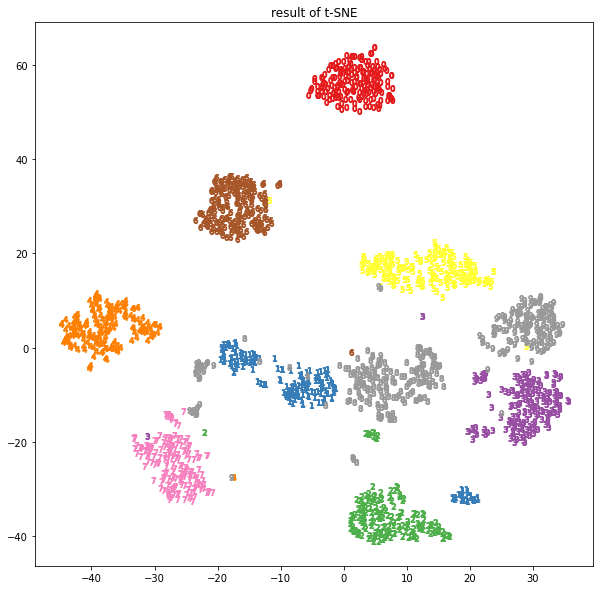

In [8]:
# 計算結果の可視化
import matplotlib.pyplot as plt
cmp = plt.get_cmap("Set1")
plt.figure(figsize = (10, 10))
for i in range(10):
    flag = labels == i
    Y_selected = Y[flag, :]
    plt.scatter(Y_selected[:,0], Y_selected[:,1], color = cmp(i), marker = f"${i}$")
plt.title("result of t-SNE")
plt.show()

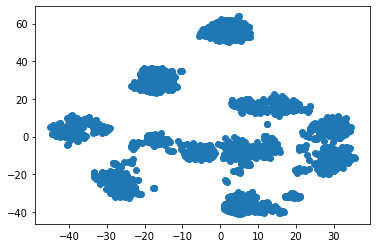

In [9]:
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

In [12]:
import numpy as np
2-3/4*np.log2(3)

0.8112781244591329

t-SNEは大域的なデータポイントの配置を保存するだけでなく、局所的な配置もまた保存するように学習することが知られています。実際のラベルが「5」であるにも関わらず「6」のクラスター近くにいるデータポイントについて、対応している画像を確認してみましょう。恐らく、「6」と似たような画像になっているはずです。

In [ ]:
# t-SNEの局所性の確認
import numpy as np
index_fail = np.where((Y[:,1].reshape(-1) < -20) & (labels == 5))
plt.imshow(X[index_fail].reshape(8, 8))
plt.show()

## D　SNEとt-SNEの仕組み
### SNEとは
**SNEのアイディア：** stochastic neighbor embeddingは、Hinton and Roweis(2003)によって提案された、データポイント間の類似度をあるデータポイントの周辺に他のデータポイントが起こる条件付き確率や同時確率に変換することで捉えようというアイディアです。これらの確率は、入力空間のデータポイント間のユークリッド距離から計算できるものとします。

例えば、データポイント$X_i$に対してデータポイント$X_j$の条件付き確率$p_{j\mid i}$を多変量正規分布でモデリングする場合、
\begin{eqnarray*}
\displaystyle p_{j\mid i}&:=&\frac{\exp\left(-\frac{\|X_j-X_i\|^2}{2\sigma_i^2}\right)}{\sum_{k\neq i}\exp\left(-\frac{\|X_k-X_i\|^2}{2\sigma_i^2}\right)}
\end{eqnarray*}
同時確率$p_{ij}$を同様にモデリングする場合、
\begin{eqnarray*}
\displaystyle p_{ij}&:=&\frac{\exp\left(-\frac{\|X_i-X_j\|^2}{2\sigma^2}\right)}{\sum_{k\neq l}\exp\left(-\frac{\|X_k-X_l\|^2}{2\sigma^2}\right)}
\end{eqnarray*}

などが用いられます。ただし、$p_{i\mid i}=0$, $p_{ii}=0$とします。

**motivation：** このようなことを考えるモチベーションはclusteringのための次元削減にあります。一般に低次元でない入力空間は、
* データの様子が分からないためclusteringを行ってもその良さの評価が難しい。
* 次元の呪いによってclusteringが失敗しやすい。

という理由から、次元削減を行ってからclusteringされるのが一般的です。ここで、例えば多次元尺度構成法などのようにユークリッド距離を保つように次元削減するのではなく、データポイント間の類似度を保つように次元削減することを目指そうというのがHintonの主張です。

**Remark.** van der Maaten and Hinton(2011)には通常の距離がclusteringに向かないことを示唆する議論があります。

### t-SNEの概要
van der Maaten and Hinton(2008)が提案したt-SNEでは、orignalな入力空間$X$におけるデータポイント間の類似度を多変量正規分布による同時確率
\begin{eqnarray*}
\displaystyle p_{ij}&:=&\frac{\exp\left(-\frac{\|X_i-X_j\|^2}{2\sigma^2}\right)}{\sum_{k\neq l}\exp\left(-\frac{\|X_k-X_l\|^2}{2\sigma^2}\right)}
\end{eqnarray*}
次元削減後の低次元空間$Y$におけるデータポイント間の類似度を自由度1のt分布による同時確率
\begin{eqnarray*}
\displaystyle q_{ij} &:=& \frac{(1+\|Y_i-Y_j\|^2)^{-1}}{\sum_{k\neq l}(1+\|Y_k-Y_l\|^2)^{-1}}
\end{eqnarray*}
で定義し、Kullback-Leibler divergence
\begin{eqnarray*}
D(p\| q) &=& \sum_{i \neq j}p_{ij}\log\frac{p_{ij}}{q_{ij}}\\
&=& \sum_{i\neq j}\log p_{ij} - p_{ij}\log q_{ij}
\end{eqnarray*}
の意味でこれらの同時確率分布が近くなるような次元圧縮を与える関数t-SNE:$X\rightarrow Y$の学習を目指します。

**t分布：** 自由度$\alpha$のt分布は、以下のような確率密度関数
\begin{eqnarray*}
f(x) = \frac{\Gamma\left(\frac{\alpha+1}{2}\right)}{\sqrt{\alpha\pi}\Gamma\left(\frac{\alpha}{2}\right)}\left(1+\frac{x^2}{\alpha}\right)^{-\left(\frac{\alpha+1}{2}\right)}
\end{eqnarray*}
で定義されます。正規分布に比べると裾が重いことが特徴です。t-SNEで低次元空間側のaffinityをt-分布で定義するアイディアの背景には、入力空間上でaffinityの高いデータポイントどうしをより近く、affinityの低いデータポイントどうしをより遠くにするためには、入力空間のaffinityを定義する正規分布より裾が重い分布を用いて低次元側のaffinityを定義したほうが良いのではないかというアイディアから来ています。

なお、低次元空間側のaffinityを正規分布で定義したSNEでは、実際に低次元空間側であまり異なるクラスター間のデータポイントが分かれない現象がしばしば起こることが当時既に実験的に知られていて、**crowding問題**と呼ばれていました。t-SNEはこのcrowding問題への対処案を考えたことに大きな貢献があると言えます。

なお、van der Maatenは自由度$\alpha$を1に固定しており、ここを調整する議論についてはあまり述べていません。また、自由度1のt-分布を用いたt-SNEは、その裾の重さから次元の呪いを受け、似ているデータポイント同士でも低次元空間では離れた配置になってしまう可能性が示唆されています。自由度を調整することによって解決できるだろうという指摘がvan der Maatenによって行われていますが、詳しくは議論されていません。

**PCAや多次元尺度構成法などとの比較：** PCAは再構成誤差を最小化するような低次元空間$Y$を求める方法でした。また、多次元尺度構成法はデータポイント間の距離を保つように低次元空間に点を配置する方法でした。いずれも、大域的にはデータポイントの配置を保ちますが、局所的なデータポイント間の配置について学習アルゴリズムには反映がありません。t-SNEなどのSNEによる次元削減では、各データポイントまわりの同時確率分布の再構成を念頭に置いているように、局所的な点の配置についても関心を持っている学習アルゴリズムになっています。

**additionalな議論：** 同時確率$p_{ij}$は外れ値に弱いという欠点が知られています。仮にデータポイント$X_i$が外れ値であった場合、任意のデータポイント$X_j$に対してユークリッド距離$\|X_i-X_j\|$が大きくなってしまいます。要するに$p_{i\cdot}$が、他の同時確率に比べていくらでも小さくなり得るわけです。するとKullback-Leibler divergenceの最小化は、データポイント$X_i$にほぼ依存せず出来てしまうため、データポイント$X_i$の低次元空間における配置は大変不安定になってしまいます。そこで、同時確率$p_{ij}$の代わりにjoint probability
\begin{eqnarray*}
p_{ij} &=& \frac{p_{j\mid i} + p_{i\mid j}}{2n}
\end{eqnarray*}
を用いることが提案されており、今では広く用いられています。こうすることで、$\sum_{j}p_{ij}>\frac{1}{2n}$とすることが出来るため、Kullback-Leibler divergenceの最小化がデータポイント$X_i$に依存しなくなるような現象を防ぐことが出来ます。

**補題** $p_{ij} = \frac{p_{j\mid i} + p_{i\mid j}}{2n}$のとき、$\sum_{j}p_{ij}>\frac{1}{2n}$が成り立つ。

**証明**
\begin{eqnarray*}
\sum_{j}p_{ij} &=& \sum_{j}\frac{p_{j\mid i} + p_{i\mid j}}{2n}\\
&=& \frac{1}{2n}\left(\sum_{j}p_{j\mid i} + \sum_{j}p_{i\mid j}\right)\\
&=& \frac{1}{2n}\left(1 + \sum_{j}p_{i\mid j}\right)\\
&>& \frac{1}{2n}
\end{eqnarray*}■

### t-SNEの学習algorithm
ここではt-SNEの学習algorithm、特に各データポイント$X_i$を中心とする条件付き確率$p_{j\mid i}$を決める分散パラメータ$\sigma_i^2$の決め方とKullback-Leibler divergenceの最小化の計算について解説します。まず、t-SNEの学習algorithmを分からない単語がある前提で紹介します。
1. 事前に設定したperplexityを用いて分散パラメータを決定し、データポイント間の類似度$p_{ij}$を求める。
2. 事前に設定した次元をもつ空間$Y=(Y_1,\cdots,Y_n)$の点を多変量正規分布$N(0,10^{-4}E)$に従ってサンプルサイズ$n$の分だけ抽出する。
3. 以下の計算を繰り返す。
    - 類似度$q_{ij}$を計算する。
    - $\displaystyle \frac{\partial D(p\| q)}{\partial Y}(Y^{(k-1)})$を計算する。
    - $\displaystyle Y^{(k)} = Y^{(k-1)} + \eta\frac{\partial D(p\| q)}{\partial Y}(Y^{(k-1)}) + \alpha(k)(Y^{(k-1)}-Y^{(k-2)})$
    
**perplexityによるデータポイント間の類似度$p_{ij}$の決定：** perplexityは各データポイント$X_i$に対して定義されるもので、データポイント$X_i$まわりの条件付き確率$p_{i}=\{p_{j\mid i}\}_{j=1}^{n}$に対して
\begin{eqnarray*}
perp(p_{i}) &:=& 2^{H(p_{i})}
\end{eqnarray*}
と定義されます。$H(p_{i}):=-\sum_{j}p_{j\mid i}\log_{2} p_{j\mid i}$です。t-SNEではperplexityはデータポイントに依らず一定として自分で設定し、設定したperplexityを満たす分散パラメータ$\sigma_i^2$を求めます。ところで、$\sigma^2$の値が大きくなると$p_{j\mid i}$は大きくなるため、perplexityもまた大きくなります。要するに、perplexityはデータポイント$X_i$から離れたデータポイントでも自分の近くに集約する性質を持ちます。

**Kullback-Leibler divergenceの最小化：** Kullback-Leibier divergenceの最小化に必要な次の公式を証明します。

**定理** $\frac{\partial D(p\| q)}{\partial Y_{i}} = 4\sum_{j}(p_{ij}-q_{ij})(1+\|Y_{i}-Y_{j}\|^2)^{-1}(Y_{i}-Y_{j})$

**証明**<br>
$d_{ij}=\|Y_{i}-Y_{j}\|^2$とおく。$Y_{i}$が変化することで変化するのは$d_{i\cdot}$のみなので、
\begin{eqnarray*}
\frac{\partial D(p\| q)}{\partial Y_{i}} &=& \sum_{j}\frac{\partial D(p\| q)}{\partial d_{ij}}\frac{\partial d_{ij}}{\partial Y_{i}}\\
&=& 2\sum_{j}\frac{\partial D(p\| q)}{\partial d_{ij}}(Y_{i}-Y_{j})
\end{eqnarray*}
ここでKullback-Leibler divergenceの定義を思いだす。
\begin{eqnarray*}
D(p\| q) &=& \sum_{k\neq l}p_{kl}\log p_{kl} - p_{kl}\log q_{kl}
\end{eqnarray*}
この式を代入して、
\begin{eqnarray*}
\frac{\partial D(p\| q)}{\partial d_{ij}} &=& -\frac{\partial \sum_{k\neq l}p_{kl}\log q_{kl}}{\partial d_{ij}}\\
&=& -\sum_{k\neq l}p_{kl}\frac{\partial \log q_{kl}}{\partial q_{kl}}\frac{\partial q_{kl}}{\partial d_{ij}}\\
&=& -\sum_{k\neq l}p_{kl}\frac{1}{q_{kl}}\frac{\partial q_{kl}}{\partial d_{ij}}
\end{eqnarray*}
を得る。今度は$q_{kl}=\frac{(1+d_{kl})^{-1}}{\sum_{m\neq n}(1+d_{mn})^{-1}}$を思い出そう。
\begin{eqnarray*}
\frac{\partial q_{ij}}{\partial d_{ij}} &=& \frac{-(1+d_{ij})^{-2}}{\sum_{k\neq l}(1+d_{kl})^{-1}}+\frac{2(1+d_{ij})^{-3}}{(\sum_{k\neq l}(1+d_{kl})^{-1})^2}\\
&=& (1+d_{ij})^{-1}(-q_{ij}+2q_{ij}^2)\\
\frac{\partial q_{kl}}{\partial d_{ij}} &=& \frac{2(1+d_{kl})^{-1}(1+d_{ij})^{-2}}{(\sum_{m\neq n}(1+d_{mn})^{-1})^2}\\
&=& 2(1+d_{ij})^{-1}q_{ij}q_{kl}\\
\end{eqnarray*}
これを代入して、
\begin{eqnarray*}
\sum_{k\neq l}p_{kl}\frac{1}{q_{kl}}\frac{\partial q_{kl}}{\partial d_{ij}} &=& -2p_{ij}\frac{1}{q_{ij}}(1+d_{ij})^{-1}q_{ij} + 2\sum_{k\neq l}p_{kl}\frac{1}{q_{kl}}(1+d_{ij})^{-1}q_{kl}q_{ij}\\
&=& -2p_{ij}(1+d_{ij})^{-1} + 2\sum_{k\neq l}p_{kl}(1+d_{ij})^{-1}q_{ij}\\
&=& -2p_{ij}(1+d_{ij})^{-1} + 2q_{ij}(1+d_{ij})^{-1}\\
\end{eqnarray*}
となり、定理を得る。■

**Remark.** 現在は**early exaggeration**といって、$p_{ij}$を定数倍した状態で学習させることが一般的です。$q_{ij}$は小さいため、低次元空間のデータポイントの位置が大きく更新され、データポイントが散らばりやすくなる効果があることが実験的に知られています。

## E　SNEおよびt-SNEの発展的な話題の紹介
### t-SNEの発展
t-SNEは、UMAPの台頭もあってか、いくつかの点で批判的に言われがちです。ここで、いくつかの点についてt-SNEの擁護をしておきたいと思います。まずt-SNEは、確かにかつては時間計算量の観点から強い不満を持たれていた手法でした。実際、exactにalgorithmを実装すると$\mathcal{O}(N^2)$の時間計算量になります。しかし、van der Maaten(2014)におけるbarnes hut t-SNEの提案によって、$\mathcal{O}(N\log N)$まで時間計算量は既に改善されている点を強調しておきたいです。また、t-SNEは新しいデータポイントが追加された場合には次元削減の計算をやり直さなければならないという不満もありましたが、こちらもvan der Maaten(2009)におけるparametric t-SNEの提案によって早々に克服されました。

### SNE以降のdeep clustering
今回SNEを紹介した大きな理由の一つに、imbalance dataに対するclustering手法の提案があります。van der Maaten(2009)は、t-SNEをparametricに行う手法を提案しました。このt-SNEの考え方はXie, Girshick and Farhadi(2016)によってdeep embedding clustering (DEC)という考え方に拡張され、特にregularized DECはimbalance dataに対する強力なclustering手法と目されています。

DECのアイディアについて概要を説明しておきましょう。DECは事前に$k$個のclusterにデータを分割することを想定するとき、低次元空間への次元圧縮と点の配置を学習する際に同時にcentroidも学習しようというものです。そこで、もとの入力空間$\mathcal{X}$から次元圧縮先の低次元空間$\mathcal{Y}$へのマッピングを、以下のようなaffinityに対するKullback Leibler divergenceを最小化するようなneural networkで表現する事を目指します。まず低次元空間のaffinityは、t-SNEと同じく自由度1のt-分布によるものです。
\begin{eqnarray*}
\displaystyle q_{ij} &:=& \frac{(1+\|Y_i-\mu_j\|^2)^{-1}}{\sum_{k\neq l}(1+\|Y_k-\mu_l\|^2)^{-1}}
\end{eqnarray*}
ここで、$\mu_i$はcentroidであることに注意してください。一方で、入力空間のaffinityは
\begin{eqnarray*}
p_{ij} &=& \frac{q_{ij}^2/f_j}{\sum_{j'}q_{ij'}^2/f_{j'}}
\end{eqnarray*}
です。入力空間のaffinityを低次元空間のaffinityを用いて定義することは不思議に見えるかもしれませんが、これは入力空間でのcentroidを事前に計算することで次元の呪いを受けないよう、計算することなしに入力空間のaffinityを定義しようというアイディアに基づいています。また、低次元空間のaffinityの2乗で定義されているのは、入力空間で近いデータポイントはより近く、離れているデータポイントはより離れた位置に低次元空間で点を配置するためです。実際はより大きな次数でも問題ないように見えますが、提案論文では実験に基づいて2乗が採用されています。